# Image regression

## Biwi Kinect Head Pose dataset

In [2]:
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
path

Path('/home/jupyter/.fastai/data/biwi_head_pose')

In [7]:
Path.BASE_PATH = path

In [9]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

There are 24 directories 01-24

In [10]:
(path/'01').ls()

(#1000) [Path('01/frame_00261_pose.txt'),Path('01/frame_00252_pose.txt'),Path('01/frame_00462_rgb.jpg'),Path('01/frame_00212_rgb.jpg'),Path('01/frame_00030_rgb.jpg'),Path('01/frame_00323_rgb.jpg'),Path('01/frame_00291_pose.txt'),Path('01/frame_00459_pose.txt'),Path('01/frame_00340_pose.txt'),Path('01/frame_00276_pose.txt')...]

We can get all the image files recursively with `get_image_files`, and then write a function to convert an image filename to its associated pose file

In [12]:
img_files = get_image_files(path)

In [13]:
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('13/frame_00462_pose.txt')

In [15]:
img_files[0]

Path('13/frame_00462_rgb.jpg')

In [18]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

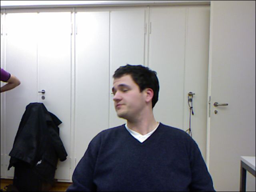

In [20]:
im.to_thumb(256)

We use this function to get the centre point from the textfiles

In [21]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

The following is an example target

In [22]:
get_ctr(img_files[0])

tensor([319.8890, 237.2442])

We can now make a `DataBlock`. It's important to observe that we shouldn't use the default splitter on this task. For the validation set, we need to use entire folders (models) the model hasn't seen before for validation. Let's use `./13` for this, using `FuncSplitter`.

In [23]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock), # PointBlock is for a target which is a location in an image
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),                
                Normalize.from_stats(*imagenet_stats) 
                # this is actually done automatically now, but we'll do it manually here. 
                # Similar to V3 of the course
               ]
)

In [24]:
dls = biwi.dataloaders(path)

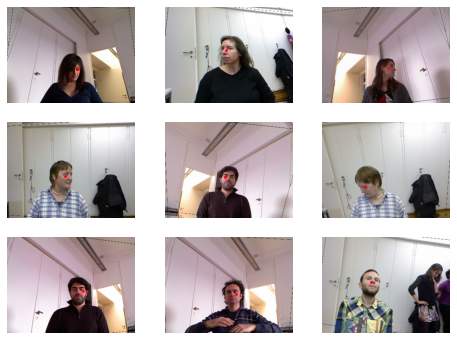

In [25]:
dls.show_batch(max_n=9, figsize=(8,6))

In [28]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

The target is `[1,2]` because we could be trying to predict `n` points in a single image, in which case the target would be `[n,2]`.

## Model

In [30]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1)) 

`y_range` is the range of the dependent variable. fastai always rescales to (-1,1) for an image. This is implemented with a scaled and shifted sigmoid on the final activations.

In [31]:
dls.loss_func

FlattenedLoss of MSELoss()

Fastai has chosen an MSE loss for this problem, which makes sense.

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=6.309573450380412e-07)

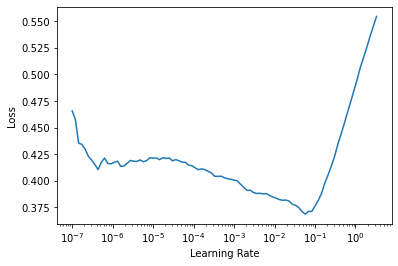

In [32]:
learn.lr_find()

In [33]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.049155,0.028310,01:01


epoch,train_loss,valid_loss,time
0,0.008039,0.001429,01:19
1,0.003188,0.000203,01:19
2,0.001488,0.000138,01:19


In [35]:
math.sqrt(learn.validate()[0])

0.011764118172655323

We are 0.01 off in a coordinate space ranging over (-1,1), which seems pretty good. We can look at our results with:

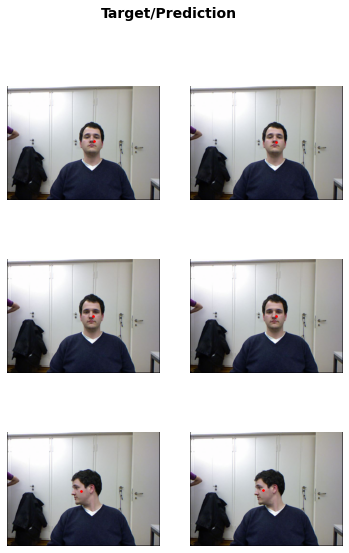

In [36]:
learn.show_results()

Looks good. Pretty amazing how little work was needed here. Especially since we're fine-tuning a model built for image classification (ImageNet) rather than image regression.